In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

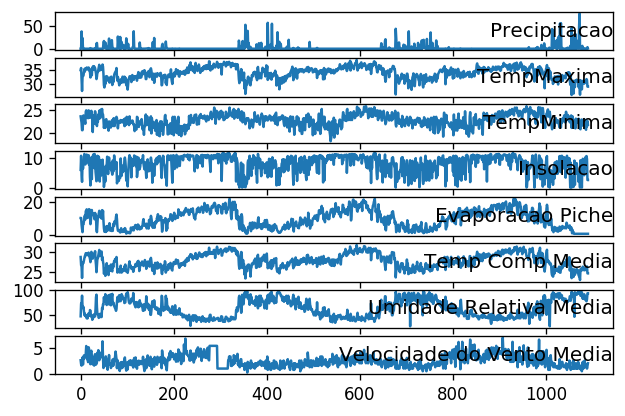

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = np.expm1(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = np.expm1(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

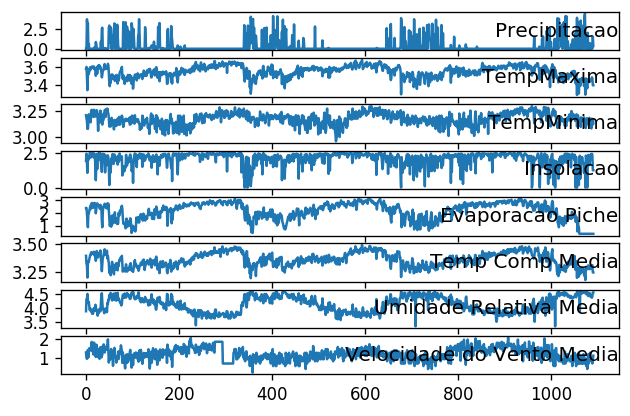

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 2.1035 - mean_squared_error: 4.7874 - val_loss: 0.9462 - val_mean_squared_error: 1.0081
Epoch 2/1000
 - 0s - loss: 0.4067 - mean_squared_error: 0.2784 - val_loss: 0.1597 - val_mean_squared_error: 0.0401
Epoch 3/1000
 - 0s - loss: 0.1368 - mean_squared_error: 0.0299 - val_loss: 0.0945 - val_mean_squared_error: 0.0120
Epoch 4/1000
 - 0s - loss: 0.0701 - mean_squared_error: 0.0079 - val_loss: 0.1339 - val_mean_squared_error: 0.0179
Epoch 5/1000
 - 0s - loss: 0.0575 - mean_squared_error: 0.0055 - val_loss: 0.0953 - val_mean_squared_error: 0.0093
Epoch 6/1000
 - 0s - loss: 0.0507 - mean_squared_error: 0.0043 - val_loss: 0.0856 - val_mean_squared_error: 0.0084
Epoch 7/1000
 - 0s - loss: 0.0492 - mean_squared_error: 0.0041 - val_loss: 0.0711 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 0s - loss: 0.0479 - mean_squared_error: 0.0038 - val_loss: 0.0675 - val_mean_squared_error: 0.0057
Epoch 9/1000
 - 0s - loss: 0.0482 -

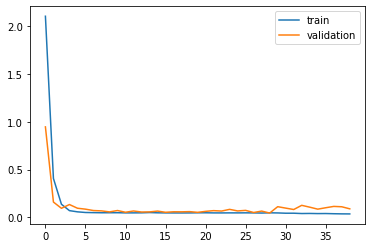


predict: [[30.97294266 22.59066308]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 3.2686 - mean_squared_error: 10.7619 - val_loss: 2.9697 - val_mean_squared_error: 8.9088
Epoch 2/1000
 - 0s - loss: 2.8233 - mean_squared_error: 8.2112 - val_loss: 2.5135 - val_mean_squared_error: 6.6341
Epoch 3/1000
 - 0s - loss: 2.2952 - mean_squared_error: 5.7512 - val_loss: 1.8634 - val_mean_squared_error: 3.9762
Epoch 4/1000
 - 0s - loss: 1.3946 - mean_squared_error: 2.7454 - val_loss: 0.8836 - val_mean_squared_error: 1.2383
Epoch 5/1000
 - 0s - loss: 0.5813 - mean_squared_error: 0.6338 - val_loss: 0.1157 - val_mean_squared_error: 0.0230
Epoch 6/1000
 - 0s - loss: 0.1186 - mean_squared_error: 0.0237 - val_loss: 0.1102 - val_mean_squared_error: 0.0144
Epoch 7/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0061 - val_loss: 0.0915 - val_mean_squared_error: 0.0097
Epoch 8/1000
 - 0s - loss: 0.0521 - mean_squared_error: 0.0045 - val_loss: 0.0570 - v

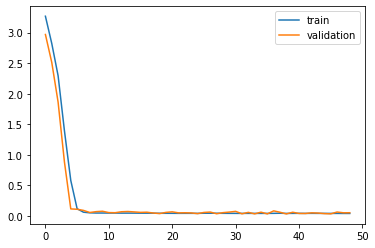


predict: [[31.41955893 22.34844387]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 3.1325 - mean_squared_error: 10.0211 - val_loss: 2.2542 - val_mean_squared_error: 5.0984
Epoch 2/1000
 - 0s - loss: 1.5224 - mean_squared_error: 2.7755 - val_loss: 0.7047 - val_mean_squared_error: 0.7698
Epoch 3/1000
 - 0s - loss: 0.3469 - mean_squared_error: 0.2373 - val_loss: 0.1971 - val_mean_squared_error: 0.0543
Epoch 4/1000
 - 0s - loss: 0.1228 - mean_squared_error: 0.0223 - val_loss: 0.0210 - val_mean_squared_error: 5.9821e-04
Epoch 5/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0057 - val_loss: 0.0161 - val_mean_squared_error: 2.5817e-04
Epoch 6/1000
 - 0s - loss: 0.0486 - mean_squared_error: 0.0039 - val_loss: 0.0107 - val_mean_squared_error: 1.3032e-04
Epoch 7/1000
 - 0s - loss: 0.0463 - mean_squared_error: 0.0037 - val_loss: 0.0110 - val_mean_squared_error: 1.3835e-04
Epoch 8/1000
 - 0s - loss: 0.0459 - mean_squared_error: 0.0035 - val_

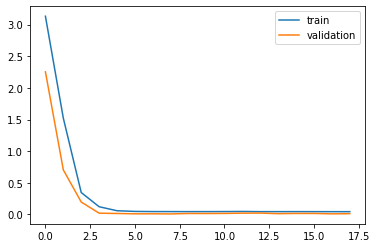


predict: [[31.81645546 22.52343437]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8231 - mean_squared_error: 3.7452 - val_loss: 0.4030 - val_mean_squared_error: 0.1854
Epoch 2/1000
 - 0s - loss: 0.2538 - mean_squared_error: 0.0935 - val_loss: 0.1333 - val_mean_squared_error: 0.0187
Epoch 3/1000
 - 0s - loss: 0.0932 - mean_squared_error: 0.0137 - val_loss: 0.1654 - val_mean_squared_error: 0.0276
Epoch 4/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0055 - val_loss: 0.0922 - val_mean_squared_error: 0.0086
Epoch 5/1000
 - 0s - loss: 0.0503 - mean_squared_error: 0.0040 - val_loss: 0.0778 - val_mean_squared_error: 0.0065
Epoch 6/1000
 - 0s - loss: 0.0491 - mean_squared_error: 0.0038 - val_loss: 0.1052 - val_mean_squared_error: 0.0111
Epoch 7/1000
 - 0s - loss: 0.0474 - mean_squared_error: 0.0037 - val_loss: 0.0966 - val_mean_squared_error: 0.0093
Epoch 8/1000
 - 0s - loss: 0.0473 - mean_squared_error: 0.0037 - val_loss: 0.0916 - va

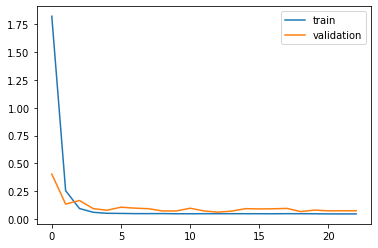


predict: [[31.5808701  22.10534007]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4193 - mean_squared_error: 6.2455 - val_loss: 1.1952 - val_mean_squared_error: 1.5474
Epoch 2/1000
 - 0s - loss: 0.6099 - mean_squared_error: 0.6043 - val_loss: 0.2629 - val_mean_squared_error: 0.0761
Epoch 3/1000
 - 0s - loss: 0.1451 - mean_squared_error: 0.0322 - val_loss: 0.0962 - val_mean_squared_error: 0.0105
Epoch 4/1000
 - 0s - loss: 0.0701 - mean_squared_error: 0.0079 - val_loss: 0.0600 - val_mean_squared_error: 0.0047
Epoch 5/1000
 - 0s - loss: 0.0555 - mean_squared_error: 0.0049 - val_loss: 0.0856 - val_mean_squared_error: 0.0079
Epoch 6/1000
 - 0s - loss: 0.0485 - mean_squared_error: 0.0038 - val_loss: 0.0780 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 0s - loss: 0.0469 - mean_squared_error: 0.0037 - val_loss: 0.0676 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0034 - val_loss: 0.0563 - va

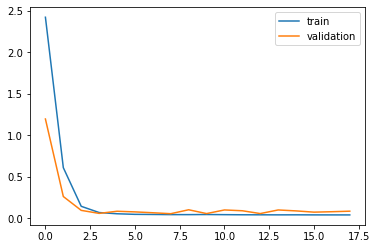


predict: [[32.42213665 22.444466  ]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.6792 - mean_squared_error: 7.5599 - val_loss: 1.5873 - val_mean_squared_error: 2.6686
Epoch 2/1000
 - 0s - loss: 0.8655 - mean_squared_error: 1.0840 - val_loss: 0.1396 - val_mean_squared_error: 0.0240
Epoch 3/1000
 - 0s - loss: 0.1712 - mean_squared_error: 0.0516 - val_loss: 0.1027 - val_mean_squared_error: 0.0107
Epoch 4/1000
 - 0s - loss: 0.0893 - mean_squared_error: 0.0126 - val_loss: 0.0647 - val_mean_squared_error: 0.0044
Epoch 5/1000
 - 0s - loss: 0.0585 - mean_squared_error: 0.0054 - val_loss: 0.0414 - val_mean_squared_error: 0.0018
Epoch 6/1000
 - 0s - loss: 0.0494 - mean_squared_error: 0.0039 - val_loss: 0.0316 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 0s - loss: 0.0472 - mean_squared_error: 0.0036 - val_loss: 0.0472 - val_mean_squared_error: 0.0022
Epoch 8/1000
 - 0s - loss: 0.0466 - mean_squared_error: 0.0036 - val_loss: 0.0353 - va

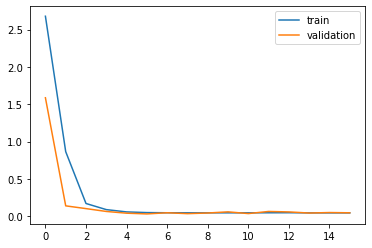


predict: [[30.08394732 22.1083811 ]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8629 - mean_squared_error: 8.6196 - val_loss: 1.7988 - val_mean_squared_error: 3.2450
Epoch 2/1000
 - 1s - loss: 1.0343 - mean_squared_error: 1.3592 - val_loss: 0.3258 - val_mean_squared_error: 0.1205
Epoch 3/1000
 - 0s - loss: 0.1969 - mean_squared_error: 0.0526 - val_loss: 0.0488 - val_mean_squared_error: 0.0025
Epoch 4/1000
 - 0s - loss: 0.0843 - mean_squared_error: 0.0106 - val_loss: 0.0286 - val_mean_squared_error: 8.4241e-04
Epoch 5/1000
 - 0s - loss: 0.0551 - mean_squared_error: 0.0049 - val_loss: 0.0570 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 0s - loss: 0.0465 - mean_squared_error: 0.0036 - val_loss: 0.0682 - val_mean_squared_error: 0.0056
Epoch 7/1000
 - 0s - loss: 0.0455 - mean_squared_error: 0.0035 - val_loss: 0.0677 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 0s - loss: 0.0462 - mean_squared_error: 0.0035 - val_loss: 0.0665 

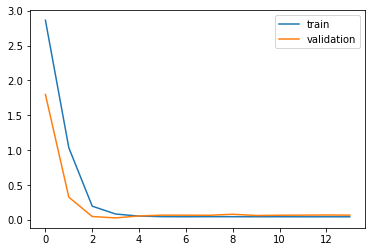


predict: [[30.50283475 23.15260432]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8694 - mean_squared_error: 8.3966 - val_loss: 1.9654 - val_mean_squared_error: 3.8956
Epoch 2/1000
 - 0s - loss: 1.3139 - mean_squared_error: 2.0289 - val_loss: 0.4989 - val_mean_squared_error: 0.3052
Epoch 3/1000
 - 0s - loss: 0.2367 - mean_squared_error: 0.0915 - val_loss: 0.1976 - val_mean_squared_error: 0.0414
Epoch 4/1000
 - 0s - loss: 0.0956 - mean_squared_error: 0.0136 - val_loss: 0.1371 - val_mean_squared_error: 0.0226
Epoch 5/1000
 - 0s - loss: 0.0682 - mean_squared_error: 0.0074 - val_loss: 0.1016 - val_mean_squared_error: 0.0164
Epoch 6/1000
 - 0s - loss: 0.0585 - mean_squared_error: 0.0054 - val_loss: 0.0756 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 0s - loss: 0.0494 - mean_squared_error: 0.0039 - val_loss: 0.0707 - val_mean_squared_error: 0.0071
Epoch 8/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0036 - val_loss: 0.0655 - va

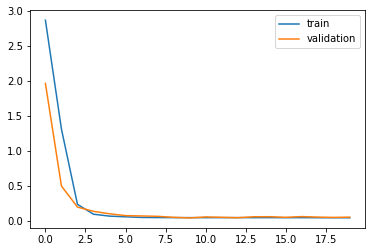


predict: [[30.52386466 23.16093821]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8668 - mean_squared_error: 8.5275 - val_loss: 2.0954 - val_mean_squared_error: 4.5868
Epoch 2/1000
 - 0s - loss: 1.4417 - mean_squared_error: 2.6733 - val_loss: 0.6465 - val_mean_squared_error: 0.5744
Epoch 3/1000
 - 0s - loss: 0.3170 - mean_squared_error: 0.1806 - val_loss: 0.2317 - val_mean_squared_error: 0.0882
Epoch 4/1000
 - 0s - loss: 0.1141 - mean_squared_error: 0.0219 - val_loss: 0.0524 - val_mean_squared_error: 0.0029
Epoch 5/1000
 - 0s - loss: 0.0543 - mean_squared_error: 0.0049 - val_loss: 0.0415 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0037 - val_loss: 0.0358 - val_mean_squared_error: 0.0024
Epoch 7/1000
 - 0s - loss: 0.0464 - mean_squared_error: 0.0036 - val_loss: 0.0431 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 0s - loss: 0.0461 - mean_squared_error: 0.0035 - val_loss: 0.0283 - va

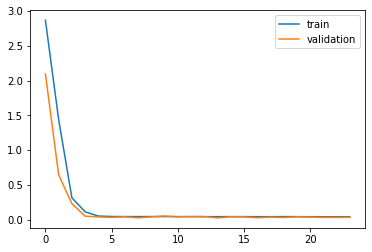


predict: [[31.82604915 22.213149  ]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2790 - mean_squared_error: 5.5010 - val_loss: 1.3300 - val_mean_squared_error: 1.7955
Epoch 2/1000
 - 0s - loss: 0.6434 - mean_squared_error: 0.6220 - val_loss: 0.3245 - val_mean_squared_error: 0.1079
Epoch 3/1000
 - 0s - loss: 0.1794 - mean_squared_error: 0.0437 - val_loss: 0.0753 - val_mean_squared_error: 0.0060
Epoch 4/1000
 - 0s - loss: 0.0712 - mean_squared_error: 0.0079 - val_loss: 0.0339 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 0s - loss: 0.0540 - mean_squared_error: 0.0047 - val_loss: 0.0310 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0040 - val_loss: 0.0353 - val_mean_squared_error: 0.0022
Epoch 7/1000
 - 0s - loss: 0.0465 - mean_squared_error: 0.0036 - val_loss: 0.0415 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0458 - mean_squared_error: 0.0035 - val_loss: 0.0298 - va

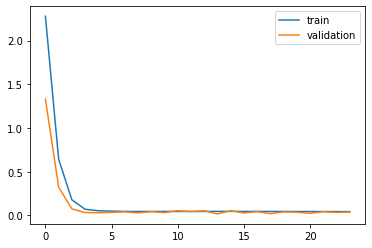


predict: [[31.15565874 21.64691159]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.7973 - mean_squared_error: 7.8972 - val_loss: 2.3246 - val_mean_squared_error: 5.4044
Epoch 2/1000
 - 0s - loss: 1.9742 - mean_squared_error: 3.9728 - val_loss: 1.3724 - val_mean_squared_error: 1.8890
Epoch 3/1000
 - 0s - loss: 0.8593 - mean_squared_error: 0.8949 - val_loss: 0.1799 - val_mean_squared_error: 0.0386
Epoch 4/1000
 - 0s - loss: 0.1541 - mean_squared_error: 0.0371 - val_loss: 0.1138 - val_mean_squared_error: 0.0147
Epoch 5/1000
 - 0s - loss: 0.0684 - mean_squared_error: 0.0071 - val_loss: 0.0870 - val_mean_squared_error: 0.0093
Epoch 6/1000
 - 0s - loss: 0.0547 - mean_squared_error: 0.0048 - val_loss: 0.0452 - val_mean_squared_error: 0.0034
Epoch 7/1000
 - 0s - loss: 0.0484 - mean_squared_error: 0.0038 - val_loss: 0.0460 - val_mean_squared_error: 0.0033
Epoch 8/1000
 - 0s - loss: 0.0469 - mean_squared_error: 0.0036 - val_loss: 0.0493 - va

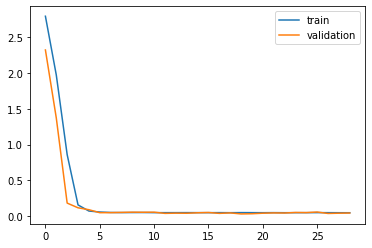


predict: [[32.24378607 23.02772276]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.6129 - mean_squared_error: 7.0040 - val_loss: 1.8627 - val_mean_squared_error: 3.5720
Epoch 2/1000
 - 0s - loss: 1.3382 - mean_squared_error: 2.1967 - val_loss: 0.7110 - val_mean_squared_error: 0.7884
Epoch 3/1000
 - 0s - loss: 0.3466 - mean_squared_error: 0.2683 - val_loss: 0.1779 - val_mean_squared_error: 0.0430
Epoch 4/1000
 - 0s - loss: 0.1101 - mean_squared_error: 0.0208 - val_loss: 0.0625 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0232 - val_mean_squared_error: 9.5449e-04
Epoch 6/1000
 - 0s - loss: 0.0513 - mean_squared_error: 0.0042 - val_loss: 0.0417 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 0s - loss: 0.0481 - mean_squared_error: 0.0037 - val_loss: 0.0470 - val_mean_squared_error: 0.0022
Epoch 8/1000
 - 0s - loss: 0.0471 - mean_squared_error: 0.0036 - val_loss: 0.0519 

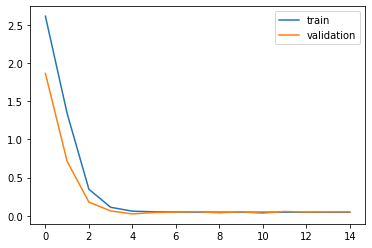


predict: [[30.4784264  22.48632469]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8834 - mean_squared_error: 8.4518 - val_loss: 2.3803 - val_mean_squared_error: 5.6857
Epoch 2/1000
 - 0s - loss: 2.1106 - mean_squared_error: 4.5697 - val_loss: 1.5087 - val_mean_squared_error: 2.2948
Epoch 3/1000
 - 0s - loss: 1.0117 - mean_squared_error: 1.2294 - val_loss: 0.1334 - val_mean_squared_error: 0.0259
Epoch 4/1000
 - 0s - loss: 0.1803 - mean_squared_error: 0.0448 - val_loss: 0.1759 - val_mean_squared_error: 0.0421
Epoch 5/1000
 - 0s - loss: 0.0687 - mean_squared_error: 0.0075 - val_loss: 0.1427 - val_mean_squared_error: 0.0338
Epoch 6/1000
 - 0s - loss: 0.0555 - mean_squared_error: 0.0052 - val_loss: 0.1075 - val_mean_squared_error: 0.0187
Epoch 7/1000
 - 0s - loss: 0.0503 - mean_squared_error: 0.0042 - val_loss: 0.1026 - val_mean_squared_error: 0.0170
Epoch 8/1000
 - 0s - loss: 0.0497 - mean_squared_error: 0.0040 - val_loss: 0.0963 - va

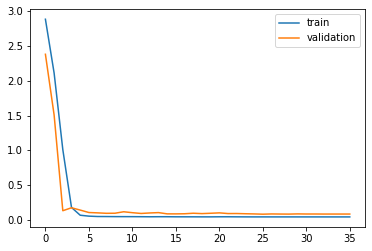


predict: [[31.31346106 22.43933532]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.3787 - mean_squared_error: 5.9107 - val_loss: 1.3139 - val_mean_squared_error: 1.7457
Epoch 2/1000
 - 0s - loss: 0.6832 - mean_squared_error: 0.6460 - val_loss: 0.4083 - val_mean_squared_error: 0.3023
Epoch 3/1000
 - 0s - loss: 0.1874 - mean_squared_error: 0.0661 - val_loss: 0.0344 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 0s - loss: 0.0738 - mean_squared_error: 0.0083 - val_loss: 0.0960 - val_mean_squared_error: 0.0124
Epoch 5/1000
 - 0s - loss: 0.0536 - mean_squared_error: 0.0046 - val_loss: 0.0955 - val_mean_squared_error: 0.0140
Epoch 6/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0041 - val_loss: 0.0780 - val_mean_squared_error: 0.0111
Epoch 7/1000
 - 0s - loss: 0.0477 - mean_squared_error: 0.0038 - val_loss: 0.0870 - val_mean_squared_error: 0.0128
Epoch 8/1000
 - 0s - loss: 0.0482 - mean_squared_error: 0.0039 - val_loss: 0.0735 - va

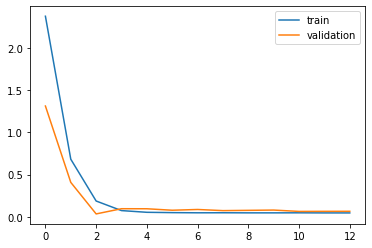


predict: [[31.75801494 23.77673007]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.9229 - mean_squared_error: 9.0214 - val_loss: 2.4404 - val_mean_squared_error: 7.2797
Epoch 2/1000
 - 0s - loss: 2.1340 - mean_squared_error: 6.9746 - val_loss: 1.6625 - val_mean_squared_error: 5.2915
Epoch 3/1000
 - 0s - loss: 1.3808 - mean_squared_error: 3.6493 - val_loss: 0.8386 - val_mean_squared_error: 1.3237
Epoch 4/1000
 - 0s - loss: 0.4661 - mean_squared_error: 0.5184 - val_loss: 0.1610 - val_mean_squared_error: 0.0461
Epoch 5/1000
 - 0s - loss: 0.1257 - mean_squared_error: 0.0273 - val_loss: 0.0182 - val_mean_squared_error: 3.7572e-04
Epoch 6/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0067 - val_loss: 0.0281 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 0s - loss: 0.0529 - mean_squared_error: 0.0046 - val_loss: 0.0669 - val_mean_squared_error: 0.0050
Epoch 8/1000
 - 0s - loss: 0.0474 - mean_squared_error: 0.0037 - val_loss: 0.0732 

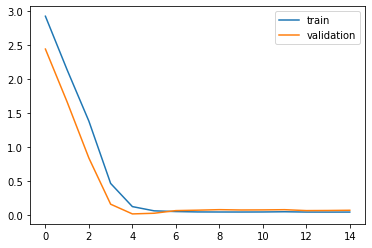


predict: [[29.19811349 21.06339703]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4105 - mean_squared_error: 6.0958 - val_loss: 1.5646 - val_mean_squared_error: 2.6576
Epoch 2/1000
 - 0s - loss: 1.0195 - mean_squared_error: 1.4396 - val_loss: 0.5686 - val_mean_squared_error: 0.3545
Epoch 3/1000
 - 0s - loss: 0.2461 - mean_squared_error: 0.1064 - val_loss: 0.1248 - val_mean_squared_error: 0.0259
Epoch 4/1000
 - 0s - loss: 0.0893 - mean_squared_error: 0.0128 - val_loss: 0.0387 - val_mean_squared_error: 0.0028
Epoch 5/1000
 - 0s - loss: 0.0534 - mean_squared_error: 0.0046 - val_loss: 0.0515 - val_mean_squared_error: 0.0032
Epoch 6/1000
 - 0s - loss: 0.0501 - mean_squared_error: 0.0041 - val_loss: 0.0517 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0042 - val_loss: 0.0431 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0037 - val_loss: 0.0417 - va

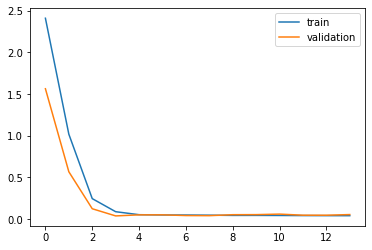


predict: [[30.09308642 21.86913444]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 3.1146 - mean_squared_error: 9.9724 - val_loss: 2.4376 - val_mean_squared_error: 6.1606
Epoch 2/1000
 - 0s - loss: 2.1844 - mean_squared_error: 5.5623 - val_loss: 1.4171 - val_mean_squared_error: 3.3848
Epoch 3/1000
 - 0s - loss: 1.3030 - mean_squared_error: 3.1195 - val_loss: 0.8129 - val_mean_squared_error: 1.1478
Epoch 4/1000
 - 0s - loss: 0.6777 - mean_squared_error: 0.8751 - val_loss: 0.1766 - val_mean_squared_error: 0.0586
Epoch 5/1000
 - 0s - loss: 0.1425 - mean_squared_error: 0.0449 - val_loss: 0.2492 - val_mean_squared_error: 0.0792
Epoch 6/1000
 - 0s - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.1681 - val_mean_squared_error: 0.0389
Epoch 7/1000
 - 0s - loss: 0.0509 - mean_squared_error: 0.0041 - val_loss: 0.1498 - val_mean_squared_error: 0.0355
Epoch 8/1000
 - 0s - loss: 0.0457 - mean_squared_error: 0.0034 - val_loss: 0.1703 - va

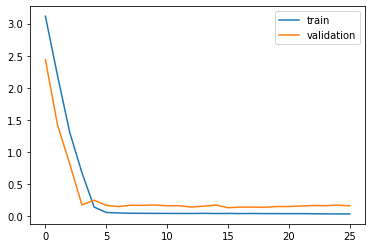


predict: [[29.18649526 19.62773155]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.6936 - mean_squared_error: 7.4588 - val_loss: 1.6040 - val_mean_squared_error: 2.6344
Epoch 2/1000
 - 0s - loss: 1.0075 - mean_squared_error: 1.3403 - val_loss: 0.3393 - val_mean_squared_error: 0.2065
Epoch 3/1000
 - 0s - loss: 0.2068 - mean_squared_error: 0.0606 - val_loss: 0.0812 - val_mean_squared_error: 0.0073
Epoch 4/1000
 - 0s - loss: 0.1011 - mean_squared_error: 0.0161 - val_loss: 0.0917 - val_mean_squared_error: 0.0124
Epoch 5/1000
 - 0s - loss: 0.0737 - mean_squared_error: 0.0089 - val_loss: 0.1417 - val_mean_squared_error: 0.0281
Epoch 6/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0060 - val_loss: 0.1518 - val_mean_squared_error: 0.0286
Epoch 7/1000
 - 0s - loss: 0.0548 - mean_squared_error: 0.0048 - val_loss: 0.1499 - val_mean_squared_error: 0.0247
Epoch 8/1000
 - 0s - loss: 0.0503 - mean_squared_error: 0.0041 - val_loss: 0.0908 - va

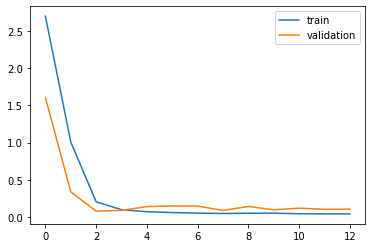


predict: [[42.33678109 21.15361669]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.2043 - mean_squared_error: 10.3167 - val_loss: 2.8600 - val_mean_squared_error: 8.1982
Epoch 2/1000
 - 0s - loss: 2.6103 - mean_squared_error: 7.0153 - val_loss: 2.0136 - val_mean_squared_error: 4.4740
Epoch 3/1000
 - 0s - loss: 1.4528 - mean_squared_error: 2.9216 - val_loss: 0.7088 - val_mean_squared_error: 0.6721
Epoch 4/1000
 - 0s - loss: 0.3068 - mean_squared_error: 0.1752 - val_loss: 0.2381 - val_mean_squared_error: 0.0638
Epoch 5/1000
 - 1s - loss: 0.1105 - mean_squared_error: 0.0198 - val_loss: 0.1176 - val_mean_squared_error: 0.0160
Epoch 6/1000
 - 1s - loss: 0.0700 - mean_squared_error: 0.0079 - val_loss: 0.0829 - val_mean_squared_error: 0.0077
Epoch 7/1000
 - 0s - loss: 0.0572 - mean_squared_error: 0.0053 - val_loss: 0.0695 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 0s - loss: 0.0500 - mean_squared_error: 0.0040 - val_loss: 0.0694 - v

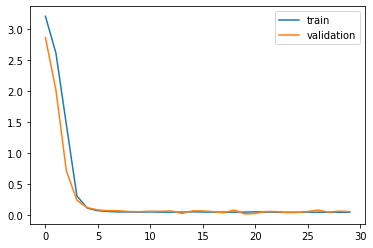


predict: [[30.63728736 21.31681613]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.5365 - mean_squared_error: 6.7342 - val_loss: 1.5074 - val_mean_squared_error: 2.2747
Epoch 2/1000
 - 1s - loss: 0.7874 - mean_squared_error: 0.8503 - val_loss: 0.2458 - val_mean_squared_error: 0.0912
Epoch 3/1000
 - 1s - loss: 0.1804 - mean_squared_error: 0.0455 - val_loss: 0.0894 - val_mean_squared_error: 0.0129
Epoch 4/1000
 - 1s - loss: 0.0797 - mean_squared_error: 0.0101 - val_loss: 0.0831 - val_mean_squared_error: 0.0069
Epoch 5/1000
 - 0s - loss: 0.0579 - mean_squared_error: 0.0054 - val_loss: 0.0803 - val_mean_squared_error: 0.0075
Epoch 6/1000
 - 1s - loss: 0.0532 - mean_squared_error: 0.0047 - val_loss: 0.0909 - val_mean_squared_error: 0.0141
Epoch 7/1000
 - 1s - loss: 0.0541 - mean_squared_error: 0.0048 - val_loss: 0.0870 - val_mean_squared_error: 0.0144
Epoch 8/1000
 - 0s - loss: 0.0524 - mean_squared_error: 0.0046 - val_loss: 0.0814 - va

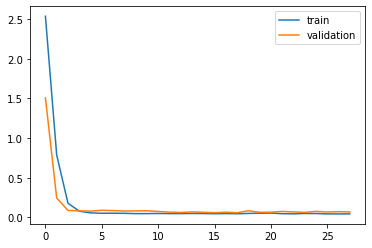


predict: [[30.17417343 22.43568639]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7440 - mean_squared_error: 7.9955 - val_loss: 1.5345 - val_mean_squared_error: 2.4271
Epoch 2/1000
 - 1s - loss: 0.8129 - mean_squared_error: 0.9555 - val_loss: 0.2541 - val_mean_squared_error: 0.0650
Epoch 3/1000
 - 0s - loss: 0.2142 - mean_squared_error: 0.0609 - val_loss: 0.0952 - val_mean_squared_error: 0.0114
Epoch 4/1000
 - 1s - loss: 0.0865 - mean_squared_error: 0.0111 - val_loss: 0.0384 - val_mean_squared_error: 0.0018
Epoch 5/1000
 - 0s - loss: 0.0691 - mean_squared_error: 0.0072 - val_loss: 0.0660 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 0s - loss: 0.0555 - mean_squared_error: 0.0048 - val_loss: 0.0521 - val_mean_squared_error: 0.0030
Epoch 7/1000
 - 0s - loss: 0.0513 - mean_squared_error: 0.0042 - val_loss: 0.0491 - val_mean_squared_error: 0.0035
Epoch 8/1000
 - 0s - loss: 0.0490 - mean_squared_error: 0.0039 - val_loss: 0.0324 - va

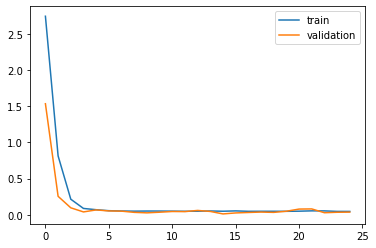


predict: [[30.00070017 22.14054018]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.5880 - mean_squared_error: 9.3552 - val_loss: 1.9552 - val_mean_squared_error: 6.8904
Epoch 2/1000
 - 0s - loss: 1.5907 - mean_squared_error: 4.7410 - val_loss: 1.1443 - val_mean_squared_error: 2.3868
Epoch 3/1000
 - 0s - loss: 0.7925 - mean_squared_error: 1.2613 - val_loss: 0.2870 - val_mean_squared_error: 0.1344
Epoch 4/1000
 - 0s - loss: 0.1569 - mean_squared_error: 0.0458 - val_loss: 0.1686 - val_mean_squared_error: 0.0355
Epoch 5/1000
 - 0s - loss: 0.0851 - mean_squared_error: 0.0112 - val_loss: 0.0207 - val_mean_squared_error: 5.0765e-04
Epoch 6/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0493 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 0s - loss: 0.0521 - mean_squared_error: 0.0044 - val_loss: 0.0598 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 0s - loss: 0.0492 - mean_squared_error: 0.0040 - val_loss: 0.0541 

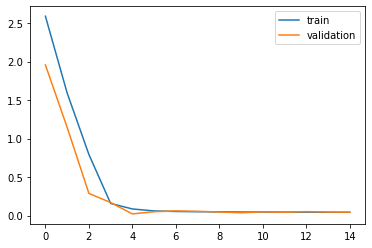


predict: [[34.09146322 23.84928832]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9812 - mean_squared_error: 9.0483 - val_loss: 2.6593 - val_mean_squared_error: 7.4112
Epoch 2/1000
 - 0s - loss: 2.3756 - mean_squared_error: 6.6535 - val_loss: 1.9281 - val_mean_squared_error: 5.3536
Epoch 3/1000
 - 0s - loss: 1.6203 - mean_squared_error: 4.6763 - val_loss: 1.3083 - val_mean_squared_error: 2.9417
Epoch 4/1000
 - 0s - loss: 1.0321 - mean_squared_error: 1.9754 - val_loss: 0.6277 - val_mean_squared_error: 0.6600
Epoch 5/1000
 - 0s - loss: 0.3139 - mean_squared_error: 0.2270 - val_loss: 0.2075 - val_mean_squared_error: 0.0663
Epoch 6/1000
 - 0s - loss: 0.1123 - mean_squared_error: 0.0216 - val_loss: 0.0424 - val_mean_squared_error: 0.0029
Epoch 7/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0060 - val_loss: 0.0420 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0520 - mean_squared_error: 0.0043 - val_loss: 0.0729 - va

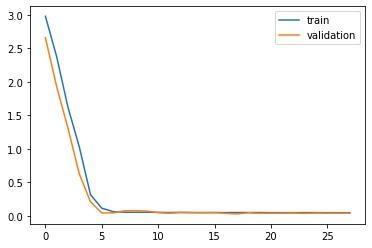


predict: [[31.95488024 22.87710353]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1215 - mean_squared_error: 9.9236 - val_loss: 2.5840 - val_mean_squared_error: 6.7678
Epoch 2/1000
 - 0s - loss: 2.1728 - mean_squared_error: 5.0683 - val_loss: 1.5403 - val_mean_squared_error: 2.9131
Epoch 3/1000
 - 0s - loss: 1.0608 - mean_squared_error: 1.8299 - val_loss: 0.4635 - val_mean_squared_error: 0.3800
Epoch 4/1000
 - 0s - loss: 0.2408 - mean_squared_error: 0.1083 - val_loss: 0.1911 - val_mean_squared_error: 0.0597
Epoch 5/1000
 - 1s - loss: 0.1005 - mean_squared_error: 0.0165 - val_loss: 0.0686 - val_mean_squared_error: 0.0052
Epoch 6/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0054 - val_loss: 0.0295 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0501 - mean_squared_error: 0.0042 - val_loss: 0.0370 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.0483 - mean_squared_error: 0.0039 - val_loss: 0.0299 - va

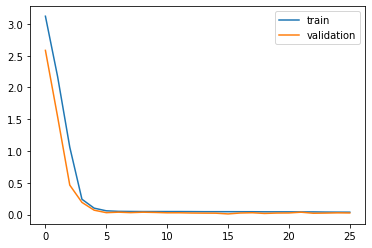


predict: [[31.2811353  22.22731597]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.0716 - mean_squared_error: 9.8856 - val_loss: 2.6681 - val_mean_squared_error: 7.7576
Epoch 2/1000
 - 0s - loss: 2.2938 - mean_squared_error: 6.8220 - val_loss: 1.6236 - val_mean_squared_error: 5.2332
Epoch 3/1000
 - 1s - loss: 1.5906 - mean_squared_error: 4.3007 - val_loss: 1.2084 - val_mean_squared_error: 2.7754
Epoch 4/1000
 - 0s - loss: 0.9714 - mean_squared_error: 1.8012 - val_loss: 0.5532 - val_mean_squared_error: 0.5936
Epoch 5/1000
 - 0s - loss: 0.2877 - mean_squared_error: 0.2085 - val_loss: 0.1554 - val_mean_squared_error: 0.0412
Epoch 6/1000
 - 0s - loss: 0.0793 - mean_squared_error: 0.0107 - val_loss: 0.1051 - val_mean_squared_error: 0.0165
Epoch 7/1000
 - 0s - loss: 0.0549 - mean_squared_error: 0.0049 - val_loss: 0.0702 - val_mean_squared_error: 0.0098
Epoch 8/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0041 - val_loss: 0.0588 - va

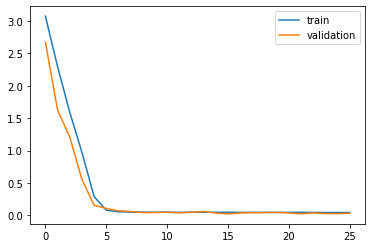


predict: [[30.98261001 22.60364789]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.0620 - mean_squared_error: 10.1937 - val_loss: 2.5814 - val_mean_squared_error: 7.9035
Epoch 2/1000
 - 0s - loss: 2.3020 - mean_squared_error: 7.7058 - val_loss: 1.9089 - val_mean_squared_error: 7.2195
Epoch 3/1000
 - 1s - loss: 1.9305 - mean_squared_error: 6.9303 - val_loss: 1.8260 - val_mean_squared_error: 5.9037
Epoch 4/1000
 - 0s - loss: 1.7363 - mean_squared_error: 5.7548 - val_loss: 1.6239 - val_mean_squared_error: 4.8560
Epoch 5/1000
 - 0s - loss: 1.5554 - mean_squared_error: 4.6311 - val_loss: 1.4479 - val_mean_squared_error: 4.0263
Epoch 6/1000
 - 1s - loss: 1.4402 - mean_squared_error: 3.9927 - val_loss: 1.3356 - val_mean_squared_error: 3.4735
Epoch 7/1000
 - 0s - loss: 1.3338 - mean_squared_error: 3.4200 - val_loss: 1.2191 - val_mean_squared_error: 2.9107
Epoch 8/1000
 - 0s - loss: 1.2134 - mean_squared_error: 2.8218 - val_loss: 1.0923 - v

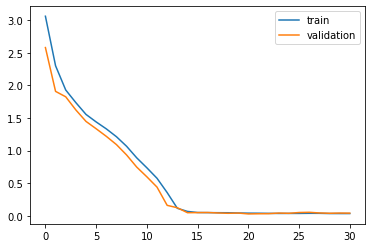


predict: [[31.82716051 22.61404989]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8163 - mean_squared_error: 8.1977 - val_loss: 1.8920 - val_mean_squared_error: 3.6257
Epoch 2/1000
 - 1s - loss: 1.3227 - mean_squared_error: 2.0096 - val_loss: 0.3225 - val_mean_squared_error: 0.1330
Epoch 3/1000
 - 1s - loss: 0.2485 - mean_squared_error: 0.0846 - val_loss: 0.1940 - val_mean_squared_error: 0.0388
Epoch 4/1000
 - 1s - loss: 0.0993 - mean_squared_error: 0.0143 - val_loss: 0.1675 - val_mean_squared_error: 0.0299
Epoch 5/1000
 - 0s - loss: 0.0738 - mean_squared_error: 0.0087 - val_loss: 0.0961 - val_mean_squared_error: 0.0092
Epoch 6/1000
 - 0s - loss: 0.0569 - mean_squared_error: 0.0053 - val_loss: 0.0883 - val_mean_squared_error: 0.0086
Epoch 7/1000
 - 0s - loss: 0.0533 - mean_squared_error: 0.0045 - val_loss: 0.0805 - val_mean_squared_error: 0.0068
Epoch 8/1000
 - 0s - loss: 0.0509 - mean_squared_error: 0.0041 - val_loss: 0.0971 - va

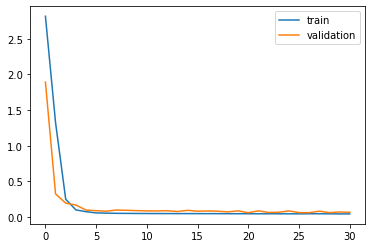


predict: [[30.65631632 21.82343975]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.1710 - mean_squared_error: 6.0286 - val_loss: 1.2621 - val_mean_squared_error: 2.9471
Epoch 2/1000
 - 0s - loss: 0.9042 - mean_squared_error: 1.5810 - val_loss: 0.3486 - val_mean_squared_error: 0.2264
Epoch 3/1000
 - 0s - loss: 0.1750 - mean_squared_error: 0.0712 - val_loss: 0.1992 - val_mean_squared_error: 0.0440
Epoch 4/1000
 - 1s - loss: 0.0787 - mean_squared_error: 0.0094 - val_loss: 0.0343 - val_mean_squared_error: 0.0014
Epoch 5/1000
 - 0s - loss: 0.0567 - mean_squared_error: 0.0051 - val_loss: 0.0787 - val_mean_squared_error: 0.0071
Epoch 6/1000
 - 1s - loss: 0.0501 - mean_squared_error: 0.0041 - val_loss: 0.0815 - val_mean_squared_error: 0.0107
Epoch 7/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0041 - val_loss: 0.0734 - val_mean_squared_error: 0.0068
Epoch 8/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0037 - val_loss: 0.0728 - va

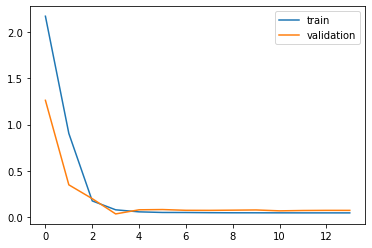


predict: [[30.00514257 21.24272566]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9640 - mean_squared_error: 9.0043 - val_loss: 2.1673 - val_mean_squared_error: 4.7300
Epoch 2/1000
 - 0s - loss: 1.6039 - mean_squared_error: 2.7351 - val_loss: 0.7849 - val_mean_squared_error: 0.6303
Epoch 3/1000
 - 0s - loss: 0.3501 - mean_squared_error: 0.1759 - val_loss: 0.3082 - val_mean_squared_error: 0.0990
Epoch 4/1000
 - 0s - loss: 0.1273 - mean_squared_error: 0.0229 - val_loss: 0.0997 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 0s - loss: 0.0656 - mean_squared_error: 0.0070 - val_loss: 0.0747 - val_mean_squared_error: 0.0058
Epoch 6/1000
 - 0s - loss: 0.0521 - mean_squared_error: 0.0043 - val_loss: 0.0662 - val_mean_squared_error: 0.0058
Epoch 7/1000
 - 1s - loss: 0.0488 - mean_squared_error: 0.0038 - val_loss: 0.0707 - val_mean_squared_error: 0.0075
Epoch 8/1000
 - 1s - loss: 0.0477 - mean_squared_error: 0.0036 - val_loss: 0.0588 - va

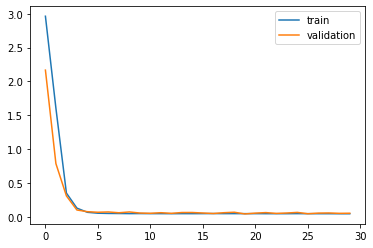


predict: [[31.22225755 22.83648623]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7586 - mean_squared_error: 7.7829 - val_loss: 1.8871 - val_mean_squared_error: 3.6378
Epoch 2/1000
 - 0s - loss: 1.2531 - mean_squared_error: 2.0096 - val_loss: 0.7903 - val_mean_squared_error: 0.7158
Epoch 3/1000
 - 0s - loss: 0.5992 - mean_squared_error: 0.4326 - val_loss: 0.3341 - val_mean_squared_error: 0.1651
Epoch 4/1000
 - 0s - loss: 0.1818 - mean_squared_error: 0.0647 - val_loss: 0.0993 - val_mean_squared_error: 0.0139
Epoch 5/1000
 - 0s - loss: 0.0771 - mean_squared_error: 0.0094 - val_loss: 0.0695 - val_mean_squared_error: 0.0080
Epoch 6/1000
 - 0s - loss: 0.0526 - mean_squared_error: 0.0043 - val_loss: 0.0504 - val_mean_squared_error: 0.0026
Epoch 7/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0037 - val_loss: 0.0572 - val_mean_squared_error: 0.0034
Epoch 8/1000
 - 0s - loss: 0.0469 - mean_squared_error: 0.0036 - val_loss: 0.0694 - va

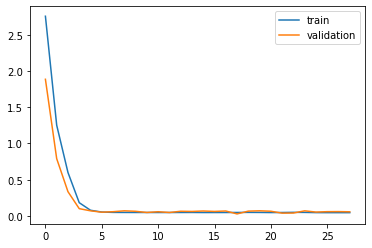


predict: [[30.27609807 21.88834049]]
real:      [[30.1 22.9]]

Maximum temperature
Test RMSE -------------------------- 3.323
Test VARIANCE ---------------------- -5.037
Test MAX-ERROR --------------------- 16.44
Test MEAN-ABSOLUTE-ERROR ----------- 1.615
Test MEDIAN-ABSOLUTE-ERROR --------- 0.8904

Minimum temperature
Test RMSE -------------------------- 0.936
Test VARIANCE ---------------------- -0.4658
Test MAX-ERROR --------------------- 1.937
Test MEAN-ABSOLUTE-ERROR ----------- 0.7936
Test MEDIAN-ABSOLUTE-ERROR --------- 0.758


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

values_scaled = np.log1p(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict)